## Setup secrets

In [1]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
HF_TOKEN = user_secrets.get_secret("HF_TOKEN")
WANDB_TOKEN = user_secrets.get_secret("WANDB_TOKEN")

## Load Dataset

In [2]:
# Downgrade fsspec and rich to match other packages' requirements
%pip install --quiet fsspec==2024.10.0 rich<14
print("✅ fsspec and rich downgraded.")

%pip install --quiet datasets pandas transformers huggingface_hub ipywidgets
print("✅ Initial libraries installed.")

# Install compatible CUDA libraries for torch 2.5.1+cu124
%pip install --quiet torch==2.5.1+cu124 torchvision==0.16.1+cu124 torchaudio==2.5.1+cu124 --extra-index-url https://download.pytorch.org/whl/cu124
print("✅ CUDA libraries installed.")


from datasets import load_dataset
# import pandas as pd

dataset = load_dataset("mteb/tweet_sentiment_extraction")
print("✅ Dataset loaded.")

/bin/bash: line 1: 14: No such file or directory
Note: you may need to restart the kernel to use updated packages.
✅ fsspec and rich downgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 4.4 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nv

README.md:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/3.63M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/465k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/27481 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3534 [00:00<?, ? examples/s]

✅ Dataset loaded.


## HuggingFace Setup

In [3]:
import huggingface_hub

try:
    # login(token=HF_TOKEN)
    huggingface_hub.login(token=HF_TOKEN)
    print("✅ Logged in to Hugging Face Hub")
except Exception as e:
    print(f"❌ Error during login: {e}")
    print("✅ Please ensure you have a valid Hugging Face token in your .env file.")
    exit(1)

✅ Logged in to Hugging Face Hub


# Import models

In [6]:
import torch
from transformers import AutoModelForSequenceClassification, AutoModelForCausalLM, AutoTokenizer

BASE_MODEL = "Qwen/Qwen2.5-0.5B"
FT_MODEL = "rtweera/Qwen2.5-0.5B_2025-04-18_11-44-30"

base_model = AutoModelForCausalLM.from_pretrained(BASE_MODEL)    
base_tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True, padding_side='left')

ft_model = AutoModelForSequenceClassification.from_pretrained(FT_MODEL, num_labels=3)
ft_tokenizer = AutoTokenizer.from_pretrained(FT_MODEL, trust_remote_code=True)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
base_model.to(device)
ft_model.to(device)

# Set to eval mode
base_model.eval()
ft_model.eval()

Qwen2ForSequenceClassification(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151665, 896, padding_idx=151643)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)

✅ Model pad_token_id set.
✅ one-shot prompts generated.
✅ Prompts tokenized.
✅ Model outputs generated.
✅ Model responses decoded.
✅ Predictions generated.
📝 Accuracy calculated: 0.53
📝 F1 score calculated: 0.46
📝 Classification report:
              precision    recall  f1-score   support

    negative       0.46      0.92      0.62       144
     neutral       0.63      0.11      0.18       204
    positive       0.62      0.73      0.67       152

    accuracy                           0.53       500
   macro avg       0.57      0.59      0.49       500
weighted avg       0.58      0.53      0.46       500

📝 Confusion matrix:



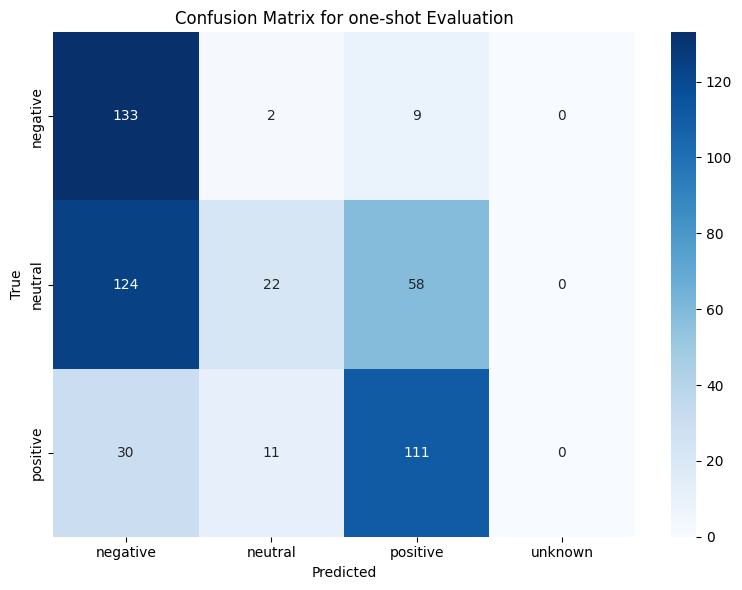

📝 Prediction Counts


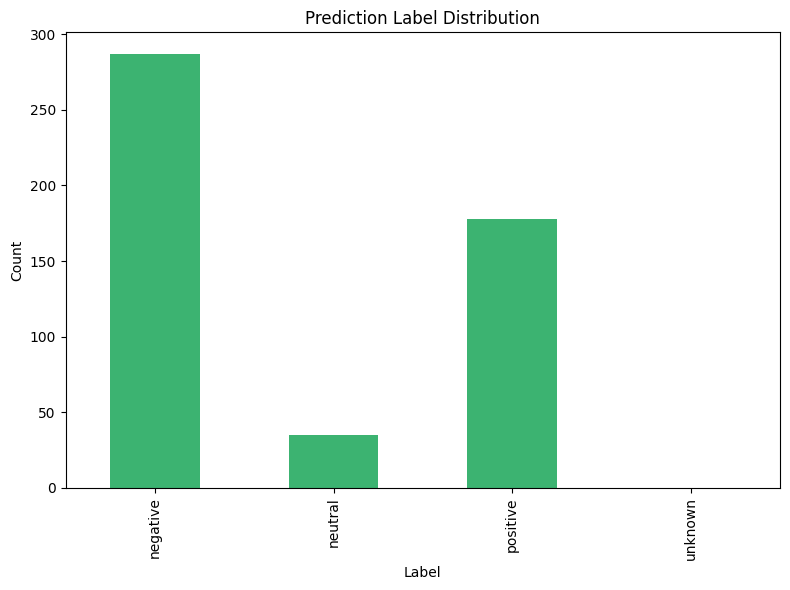

In [28]:
# %debug
from IPython.core.debugger import set_trace
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def get_zero_shot_prompt(test_dataset):
    texts = test_dataset['text']
    labels = test_dataset['label_text']
    prompts = []
    for text in texts:
        prompt = f"Please classify the following tweet as `positive`, `negative`, or `neutral`: {text}"
        prompts.append(prompt)
    return prompts, labels

def get_one_shot_prompt(test_dataset):
    texts = test_dataset['text']
    labels = test_dataset['label_text']
    prompts = []
    for text in texts:
        prompt = f"Please classify the sentiment of the following tweet as `positive`, `negative`, or `neutral`. Here's an example:\n\nTweet: This is the best day ever!\nSentiment: positive\n\nTweet: {text}\nSentiment:"
        prompts.append(prompt)
    return prompts, labels

def get_few_shot_prompt(test_dataset):
    texts = test_dataset['text']
    labels = test_dataset['label_text']
    prompts = []
    for text in texts:
        prompt = f"Please classify the sentiment of the following tweets as `positive`, `negative`, or `neutral`. Here are a few examples:\n\nTweet: I am so happy right now!\nSentiment: positive\n\nTweet: This is absolutely terrible.\nSentiment: negative\n\nTweet: The weather is cloudy today.\nSentiment: neutral\n\nTweet: I'm feeling quite disappointed.\nSentiment: negative\n\nTweet: {text}\nSentiment:"
        prompts.append(prompt)
    return prompts, labels

def get_prediction_from_response(response):
    if "positive" in response and "negative" not in response and "neutral" not in response:
        return "positive"
    elif "negative" in response and "positive" not in response and "neutral" not in response:
        return "negative"
    elif "neutral" in response and "positive" not in response and "negative" not in response:
        return "neutral"
    else:
        return "unknown"

def evaluate_base_model(tokenizer, model, test_dataset, eval_type):
    if eval_type == 'zero-shot':
        prompts, labels = get_zero_shot_prompt(test_dataset)
    elif eval_type == 'one-shot':
        prompts, labels = get_one_shot_prompt(test_dataset)
    elif eval_type == 'few-shot':
        prompts, labels = get_few_shot_prompt(test_dataset)
    else:
        raise ValueError(f"Invalid eval_type: {eval_type}")
    print(f"✅ {eval_type} prompts generated.")

    inputs = tokenizer(prompts, return_tensors="pt", padding=True).to(device)
    print(f"✅ Prompts tokenized.")

    with torch.no_grad():
        outputs = model.generate(
            inputs.input_ids, 
            attention_mask=inputs.attention_mask,
            do_sample=False,
            max_new_tokens=10,
            pad_token_id=tokenizer.eos_token_id  # Set the pad token ID for generation
        )
    print(f"✅ Model outputs generated.")

    # Decode response
    responses = []
    for i in range(len(outputs)):
        # print(inputs.input_ids[i].shape)
        # print(f"❓ Prompt {i}: {prompts[i]}")
        input_length = inputs.input_ids[i].shape[0]
        response = tokenizer.decode(outputs[i][input_length:], skip_special_tokens=True)
        # print(f"🗯 Response {i}: {response}")
        responses.append(response)
        # print(f"✅ Response {i} decoded.")
    print(f"✅ Model responses decoded.")

    # Formatting responses
    cleaned_responses = list(map(lambda x: x.strip().lower(), responses))

    # Get predictions
    predictions = list(map(get_prediction_from_response, cleaned_responses))
    print(f"✅ Predictions generated.")

    # Calculate accuracy
    accuracy = accuracy_score(labels, predictions)
    print(f"📝 Accuracy calculated: {accuracy:.2f}")
    f1 = f1_score(labels, predictions, average='weighted', zero_division=0)
    print(f"📝 F1 score calculated: {f1:.2f}")
    print(f"📝 Classification report:\n{classification_report(labels, predictions, zero_division=0)}")

    print("📝 Confusion matrix:\n")
    cm = pd.crosstab(
        pd.Series(labels, name='Actual'),
        pd.Series(predictions, name='Predicted'),
        rownames=['Actual'],
        colnames=['Predicted'],
        dropna=False
    )

    # Reindex rows and columns to ensure desired order
    cm = cm.reindex(index=['negative', 'neutral', 'positive'], columns=['negative', 'neutral', 'positive', 'unknown'], fill_value=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {eval_type} Evaluation')
    plt.tight_layout()
    plt.show()

    print("📝 Prediction Counts")
    prediction_counts = pd.Series(predictions).value_counts()
    ordered_counts = prediction_counts.reindex(['negative', 'neutral', 'positive', 'unknown'], fill_value=0)
    ordered_counts.plot(kind='bar', color='mediumseagreen', figsize=(8, 6))
    plt.title("Prediction Label Distribution")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# base_tokenizer.padding_token = base_tokenizer.eos_token
base_model.config.pad_token_id = base_tokenizer.pad_token_id # Set the pad token ID in the model's config
print(f"✅ Model pad_token_id set.")
evaluate_base_model(base_tokenizer, base_model, dataset['test'][2500:3000], eval_type='one-shot')
